In [2]:
import matplotlib.pyplot as plt
from matplotlib import rc
rc('text', usetex=True)
rc('font',**{'family':'sans-serif','sans-serif':['Helvetica']})
plt.rcParams['axes.labelsize'] = 20
plt.rcParams['axes.titlesize'] = 20

plt.rcParams['xtick.major.size'] = 18
plt.rcParams['ytick.major.size'] = 18
plt.rc('legend', fontsize=20)
import seaborn as sns
import pandas as pd
import numpy as np

In [3]:
def parse_nvidia_smi_output(path, start=None, stop=None):
    df = pd.read_csv(path)
    df = df[df["index"] == 0]
    df = df.reset_index(drop=True)
    f, ax = plt.subplots(1,1, figsize=(10,10))

    if start is not None:
        df = df.iloc[start:]
    if stop is not None:
        df = df.iloc[:stop]

    df[' power.draw [W]'] =df[' power.draw [W]'].apply(lambda x: float(x.split(" ")[1])) 
    sns.lineplot(x=list(range(len(df))), y=df[' power.draw [W]'], ax=ax)
    print(df[' power.draw [W]'].mean())

In [4]:
# parse_nvidia_smi_output("/g/g13/jones289/workspace/hd-cuda-master/hdpy/molformer_nvidia-smi_output_1k.csv")
# test_path = "/g/g13/jones289/workspace/hd-cuda-master/hdpy/hdbind-rp-molformer-1k_nvidia-smi_test.csv"
# parse_nvidia_smi_output(test_path)

In [5]:
# parse_nvidia_smi_output(test_path,
                        # start=0, stop=110)

In [4]:
from pathlib import Path

TIME_PER_SAMPLE=.05 # this corresponds to milliseconds, sampling interval for variorum
N=41127
def parse_var_monitor_output(path):
    try:
        path = Path(path)

        mode = path.parent.name.split("_")[-1]
        model = path.parent.name.split("_")[0]
        timing_path = path.parent.parent / Path(f"{model}_timing_{mode}.npy")
        timing_data = np.load(timing_path)
        mean_time_crit, std_time_crit = timing_data


        df = pd.read_csv(path)
        # print(df.columns)
        gpu_power = df['GPU_0 Power (W)'].values.mean()
        cpu_power = df[['Socket_0 Power (W)', 'Socket_1 Power (W)']].mean().sum()
        
        total_time = TIME_PER_SAMPLE * df.shape[0]
        mean_time = total_time / N


        # energy = (gpu_power + cpu_power) * mean_time
        # energy_err = (gpu_power + cpu_power) * std_time
        # print(path, cpu_power, gpu_power, mean_time, std_time, energy, energy_err)

        cpu_energy = cpu_power * mean_time
        crit_energy = (cpu_power + gpu_power) * mean_time_crit
        # cpu_energy_err = cpu_power * std_time
        # print(path, cpu_power, gpu_power, mean_time, std_time, energy, energy_err)

        result_dict = {
                        "path": path, "model": model, "mode": mode,
                        "cpu_power": cpu_power, "gpu_power": gpu_power,
                        "mean_time_crit": mean_time_crit, "std_time_crit": std_time_crit, 
                        "total_time": total_time, "mean_time": total_time/N,
                        "cpu_energy": cpu_energy,
                        "crit_energy": crit_energy
                       }
        
        return pd.DataFrame(result_dict, index=[0])
        # return df
    # except FileNotFoundError as e:
    except Exception as e:
        print(e)
        return


# parse_var_monitor_output("/g/g13/jones289/workspace/hd-cuda-master/hdpy/hdbind-directecfp-1k-4_variorum_test/lassen723.var_monitor.dat")
# parse_var_monitor_output("/g/g13/jones289/workspace/hd-cuda-master/hdpy/hdbind-directecfp-1k-4_variorum_encode/lassen723.var_monitor.dat")
# parse_var_monitor_output("/g/g13/jones289/workspace/hd-cuda-master/hdpy/mlp-large-1024-1_variorum_test/lassen723.var_monitor.dat")
# parse_var_monitor_output("/g/g13/jones289/workspace/hd-cuda-master/hdpy/mlp-large-1024-1_variorum_encode/lassen723.var_monitor.dat")



Index(['Socket_0 Power (W)', 'Mem_0 Power (W)', 'GPU_0 Power (W)',
       'GPU_1 Power (W)', 'Socket_1 Power (W)', 'Mem_1 Power (W)',
       'GPU_2 Power (W)', 'GPU_3 Power (W)'],
      dtype='object')


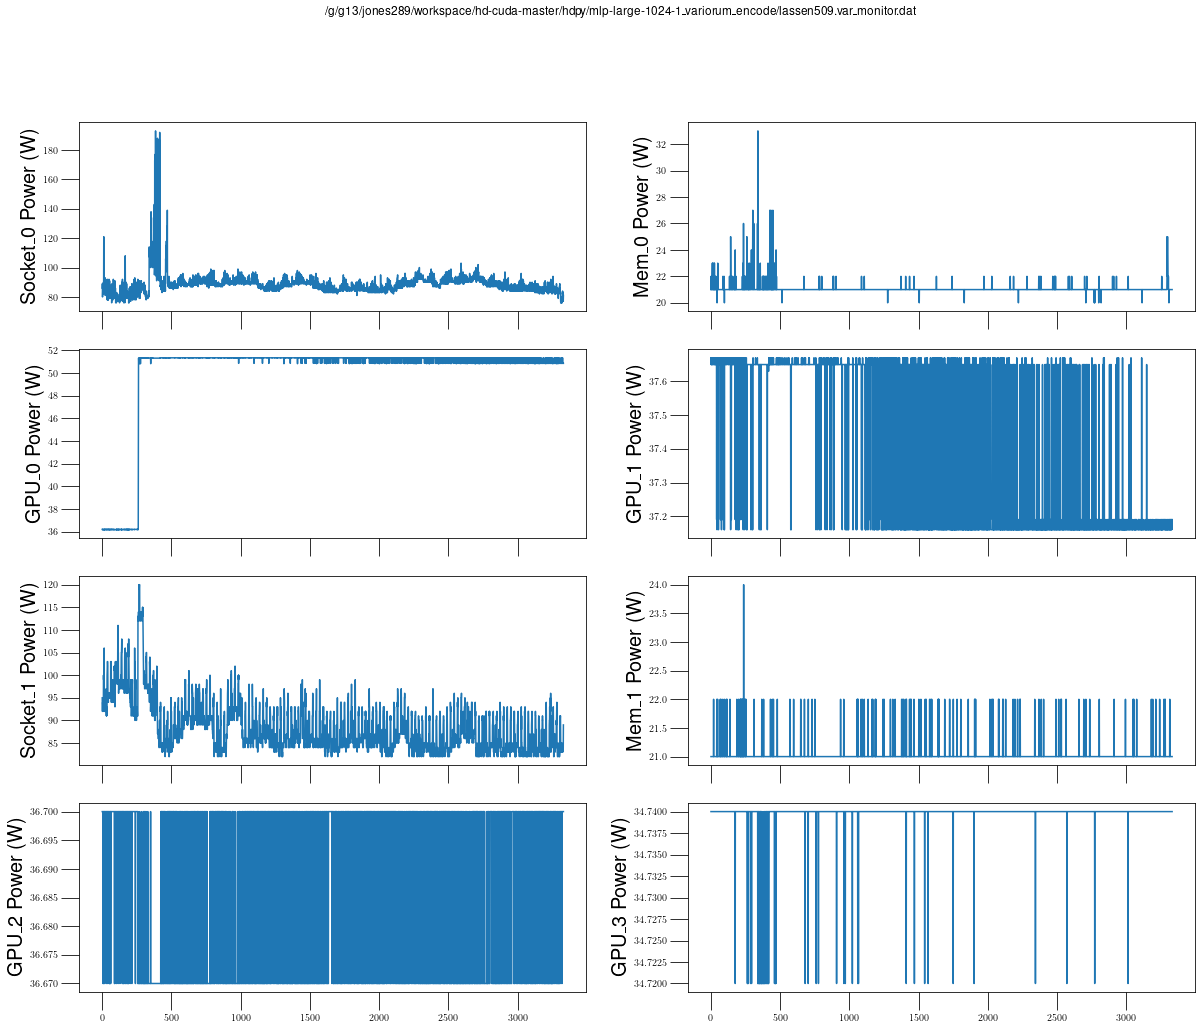

In [5]:
def plot_variorum(path):
    f, ax = plt.subplots(4,2, figsize=(20,16), sharex=True)
    ax = ax.flatten()
    df = pd.read_csv(path)
    cols = df.columns[3:]
    print(cols)

    for idx, col in enumerate(cols):
        
        ax[idx].plot(df[col].values)
        ax[idx].set_ylabel(col)

    f.suptitle(path)


plot_variorum("/g/g13/jones289/workspace/hd-cuda-master/hdpy/mlp-large-1024-1_variorum_encode/lassen509.var_monitor.dat")

In [6]:
def collect_energy_metrics(path_list):
    result_list = []
    for p in path_list:
        result_list.append(parse_var_monitor_output(p))
        # plot_variorum(p)

    df = pd.concat([x for x in result_list if x is not None])
    df = df.reset_index(drop=True)
    return df

In [7]:
encode_path_list = list(Path("/g/g13/jones289/workspace/hd-cuda-master/hdpy").glob("*_variorum_encode/*.dat"))
test_path_list = list(Path("/g/g13/jones289/workspace/hd-cuda-master/hdpy").glob("*_variorum_test/*.dat"))

encode_df = collect_energy_metrics(encode_path_list)
test_df = collect_energy_metrics(test_path_list)

energy_df = pd.concat([encode_df, test_df])
energy_df
# for p in :
    # parse_var_monitor_output(p)

,path,model,mode,cpu_power,gpu_power,mean_time_crit,std_time_crit,total_time,mean_time,cpu_energy,crit_energy
0,/g/g13/jones289/workspace/hd-cuda-master/hdpy/...,hdbind-directecfp-1k-1,encode,167.697008,52.099446,0.000358,0.000005,157.10,0.003820,0.640582,0.078604
1,/g/g13/jones289/workspace/hd-cuda-master/hdpy/...,hdbind-molformer-decfp-combo-1k,encode,162.919555,51.759582,0.000237,0.001656,418.30,0.010171,1.657044,0.050777
2,/g/g13/jones289/workspace/hd-cuda-master/hdpy/...,hdbind-rp-molformer-1k,encode,155.403642,50.674308,0.000160,0.003338,151.00,0.003672,0.570573,0.033052
3,/g/g13/jones289/workspace/hd-cuda-master/hdpy/...,mlp-large-1024-1,encode,176.833083,50.051990,0.000359,0.000002,166.55,0.004050,0.716112,0.081510
4,/g/g13/jones289/workspace/hd-cuda-master/hdpy/...,mlp-small-1024-1,encode,176.493196,50.326145,0.000361,0.000002,165.35,0.004020,0.709586,0.081981
0,/g/g13/jones289/workspace/hd-cuda-master/hdpy/...,hdbind-directecfp-1k-1,test,165.021356,50.100431,0.000257,0.000030,559.55,0.013605,2.245184,0.055367
1,/g/g13/jones289/workspace/hd-cuda-master/hdpy/...,hdbind-molformer-decfp-combo-1k,test,165.947292,50.454964,0.000253,0.000077,377.55,0.009180,1.523413,0.054688
2,/g/g13/jones289/workspace/hd-cuda-master/hdpy/...,hdbind-rp-molformer-1k,test,172.086039,49.267354,0.000246,0.000036,329.50,0.008012,1.378713,0.054502
3,/g/g13/jones289/workspace/hd-cuda-master/hdpy/...,mlp-large-1024-1,test,151.807486,50.403069,0.000332,0.000028,279.20,0.006789,1.030580,0.067059
4,/g/g13/jones289/workspace/hd-cuda-master/hdpy/...,mlp-small-1024-1,test,173.054892,51.743254,0.000196,0.000027,225.90,0.005493,0.950546,0.044093


In [9]:
energy_df["cpu_energy"]

0    0.640582
1    1.657044
2    0.570573
3    0.716112
4    0.709586
0    2.245184
1    1.523413
2    1.378713
3    1.030580
4    0.950546
Name: cpu_energy, dtype: float64

In [15]:

col_list = ["1", "10", "100", "1000", "10000", "100000"]
# col_list = ["1", "10", "100", "1000"]

def screen_cost(df, energy_col):

    molformer_llm_energy = 1.63E-01

    # screen_dict = {"Model": [], "Device":[],	"Encode (J/mol)": [], "Test (J/mol)": [], "1": [], "10": [], "100": [],	"1000": [],	"10000": [], "100000": []}
    screen_dict = {"Model": [], "Device":[],	"Encode (J/mol)": [], "Test (J/mol)": []}
    for col_val in col_list:
        screen_dict.update({col_val: []})

    for model, model_df in df.groupby("model"):

        screen_dict["Model"].append(model)
        screen_dict["Device"].append("GPU")
        encode_df = model_df[model_df["mode"] == "encode"]
        test_df = model_df[model_df["mode"] == "test"]
        
        encode_energy = encode_df[energy_col].values.squeeze()

        if "molformer" in model:
            encode_energy += molformer_llm_energy

        test_energy = test_df[energy_col].values.squeeze()

        screen_dict["Encode (J/mol)"].append(encode_energy)
        screen_dict["Test (J/mol)"].append(test_energy)

        for i in col_list:

            screen_cost = encode_energy + (float(i) * test_energy)
            screen_dict[i].append(screen_cost)
    
    # print(pd.DataFrame(screen_dict))
    # add FPGA numbers

    hdb_df = df[df["model"].apply(lambda x: "mlp" not in x)]

    # print(hdb_df)


    # fpga_test_energy = 1.10e-5
    fpga_test_energy=1.06426E-05

    for model, model_df in hdb_df.groupby("model"):
        screen_dict["Model"].append(model)
        screen_dict["Device"].append("FPGA")
        encode_df = model_df[model_df["mode"] == "encode"]
        
        encode_energy = encode_df[energy_col].values.squeeze()

        if "molformer" in model:
            encode_energy += molformer_llm_energy # this is the value of the per/mol energy cost I got from molformer on pascal

        screen_dict["Encode (J/mol)"].append(encode_energy)
        cpu_energy = model_df["cpu_energy"].values.squeeze()
        # print(cpu_energy)

        screen_dict["Test (J/mol)"].append(fpga_test_energy + cpu_energy)

        for i in col_list:

            screen_cost = encode_energy + (float(i) * fpga_test_energy)
            screen_dict[i].append(screen_cost)

    screen_df = pd.DataFrame(screen_dict)
    # print(screen_dict)


    '''
    improve_dict = {"Model": [], "Device": [], "mlp_large_improvement": []}
    for (model, device), model_df in screen_df.groupby(["Model", "Device"]):
        for i in col_list:
            
            mlp_large_energy = screen_df[screen_df["Model"] == "mlp-large-1024-1"][i].values.squeeze()
            model_energy = model_df[i].values.squeeze()

            improve_fact = mlp_large_energy / model_energy
            # print(model, device, i, improve_fact)

            improve_dict["Model"].append(model)
            improve_dict["Device"].append(device)
            improve_dict["mlp_large_improvement"].append(improve_fact)
    
    improve_df = pd.DataFrame(improve_dict)

    screen_df = screen_df.merge(improve_df, on=["Model", "Device"])
    '''
    return screen_df 


screen_df = screen_cost(df=energy_df, energy_col="crit_energy")
screen_df

,Model,Device,Encode (J/mol),Test (J/mol),1,10,100,1000,10000,100000,mlp_large_improvement
0,hdbind-directecfp-1k-1,GPU,0.07860393791890297,0.05536674393069127,0.133971,0.632271,5.615278,55.445348,553.746043,5536.752997,1.108966
1,hdbind-directecfp-1k-1,GPU,0.07860393791890297,0.05536674393069127,0.133971,0.632271,5.615278,55.445348,553.746043,5536.752997,1.189514
2,hdbind-directecfp-1k-1,GPU,0.07860393791890297,0.05536674393069127,0.133971,0.632271,5.615278,55.445348,553.746043,5536.752997,1.208732
3,hdbind-directecfp-1k-1,GPU,0.07860393791890297,0.05536674393069127,0.133971,0.632271,5.615278,55.445348,553.746043,5536.752997,1.210923
4,hdbind-directecfp-1k-1,GPU,0.07860393791890297,0.05536674393069127,0.133971,0.632271,5.615278,55.445348,553.746043,5536.752997,1.211145
5,hdbind-directecfp-1k-1,GPU,0.07860393791890297,0.05536674393069127,0.133971,0.632271,5.615278,55.445348,553.746043,5536.752997,1.211168
6,hdbind-molformer-decfp-combo-1k,GPU,0.21377746604169393,0.054688358110276086,0.268466,0.760661,5.682613,54.902136,547.097359,5469.049588,0.553400
7,hdbind-molformer-decfp-combo-1k,GPU,0.21377746604169393,0.054688358110276086,0.268466,0.760661,5.682613,54.902136,547.097359,5469.049588,0.988740
8,hdbind-molformer-decfp-combo-1k,GPU,0.21377746604169393,0.054688358110276086,0.268466,0.760661,5.682613,54.902136,547.097359,5469.049588,1.194409
9,hdbind-molformer-decfp-combo-1k,GPU,0.21377746604169393,0.054688358110276086,0.268466,0.760661,5.682613,54.902136,547.097359,5469.049588,1.222904


In [48]:
green_color_pal = sns.color_palette("Greens", 10)
blue_color_pal = sns.color_palette("Blues", 10)
red_color_pal = sns.color_palette("Reds", 10)
purple_color_pal = sns.color_palette("Purples", 10)
# rocket_color_pal = sns.color_palette("rocket", 10)



plot_dict = {
            # "HDB-RPFP (1k) (FPGA)": green_color_pal[3],
            # "HDB-RPFP (1k) (GPU)": green_color_pal[5],
            ## "HDB-RPFP (10k) (GPU)": green_color_pal[8], 
            "mlp-small-1024-1": ("MLP-small", red_color_pal[5]),
            "mlp-large-1024-1": ("MLP-large", red_color_pal[9]),
            "hdbind-molformer-decfp-combo-1k": ("HDB-Combo", green_color_pal[9]),
            "hdbind-directecfp-1k-1": ("HDB-DECFP", green_color_pal[3]),
            "hdbind-rp-molformer-1k": ("HDB-MoLFormer", green_color_pal[7])
    }




def main(df):
    # df = pd.read_csv("energy.csv", sep="\t")

    # import pdb
    # pdb.set_trace()

    f, ax = plt.subplots(1,1, figsize=(16,10))
    # ax.set_xscale("log")
    # f.clf()

    zorder = 1
    for idx, ((model, device), model_df) in enumerate(df.groupby(["Model", "Device"])):

        # print(model)
        if model in plot_dict.keys():
            x = [int(x) for x in col_list]
            y = model_df[col_list].values.reshape(-1)
            
            color = plot_dict[model][1]

            model_title = f"{plot_dict[model][0]} ({device})"

            print(model_title)

            # import pdb
            # pdb.set_trace()
            # '''
            # device= "GPU"
            linestyle = "-"
            label=model_title
            linewidth=4
            s=200
            if "mlp" not in model.lower():
                zorder = idx
                # label = model.replace("(1k)", "")
                # device = model.split(" ")[-1]
                # print(device)
                if device == "FPGA":
                    linestyle = "-."
            else:
                # label = "MLP-small"
                linewidth = 6
                zorder = 0
                linestyle = "--"

            print(len(x), len(y))
            print(x,y)
            # sns.lineplot(x=x, y=y, label=label, ax=ax, markers="x", color=color, linestyle=linestyle, linewidth=linewidth,
                                # zorder=zorder)
            # sns.scatterplot(x=x, y=y, ax=ax, color=color, s=s, zorder=zorder)
            # '''


    ax.set_yscale("log")
    ax.set_xscale("log")
    ax.set_ylabel("$\log(E/{mol})$")
    ax.set_xlabel("$log$($N_{Protein})$")

    ax.xaxis.set_tick_params(labelsize=16)
    ax.yaxis.set_tick_params(labelsize=16)

    plt.tight_layout()
    plt.savefig("hdbind_energy.png", dpi=450)
main(screen_df)

HDB-DECFP (FPGA)
> /var/tmp/jones289/ipykernel_46996/685985159.py(51)main()
     49             # '''
     50             # device= "GPU"
---> 51             linestyle = "-"
     52             label=model_title
     53             linewidth=4

                     Model Device       Encode (J/mol)  \
30  hdbind-directecfp-1k-1   FPGA  0.07860393791890297   
31  hdbind-directecfp-1k-1   FPGA  0.07860393791890297   
32  hdbind-directecfp-1k-1   FPGA  0.07860393791890297   
33  hdbind-directecfp-1k-1   FPGA  0.07860393791890297   
34  hdbind-directecfp-1k-1   FPGA  0.07860393791890297   
35  hdbind-directecfp-1k-1   FPGA  0.07860393791890297   

                                Test (J/mol)         1       10       100  \
30  [0.6405922556522529, 2.2451950713207918]  0.078615  0.07871  0.079668   
31  [0.6405922556522529, 2.2451950713207918]  0.078615  0.07871  0.079668   
32  [0.6405922556522529, 2.2451950713207918]  0.078615  0.07871  0.079668   
33  [0.6405922556522529, 2.2451950713207

In [93]:
screen_df.columns

Index(['Model', 'Device', 'Encode (J/mol)', 'Test (J/mol)', '1', '10', '100',
       '1000', '10000', '100000'],
      dtype='object')

In [103]:
screen_df['Encode (J/mol)'] = screen_df['Encode (J/mol)'].astype(float)
screen_df['Test (J/mol)'] = screen_df['Test (J/mol)'].astype(float)

round_df = screen_df.round({'Encode (J/mol)': 3, 'Test (J/mol)': 6, '1': 3, '10': 3, '100': 3, '1000': 3, '10000': 3, '100000': 3})
print(round_df)
# print(round_df['Encode (J/mol)'])
round_df.to_latex("hdbind_latex_energy_costs.tex", index=False)

                             Model Device  Encode (J/mol)  Test (J/mol)  \
0           hdbind-directecfp-1k-1    GPU           0.079      0.055367   
1  hdbind-molformer-decfp-combo-1k    GPU           0.214      0.054688   
2           hdbind-rp-molformer-1k    GPU           0.196      0.054502   
3                 mlp-large-1024-1    GPU           0.082      0.067059   
4                 mlp-small-1024-1    GPU           0.082      0.044093   
5           hdbind-directecfp-1k-1   FPGA           0.079      0.000011   
6  hdbind-molformer-decfp-combo-1k   FPGA           0.214      0.000011   
7           hdbind-rp-molformer-1k   FPGA           0.196      0.000011   

       1     10    100    1000    10000    100000  
0  0.134  0.632  5.615  55.445  553.746  5536.753  
1  0.268  0.761  5.683  54.902  547.097  5469.050  
2  0.251  0.741  5.646  54.698  545.215  5450.386  
3  0.149  0.752  6.787  67.140  670.667  6705.936  
4  0.126  0.523  4.491  44.175  441.007  4409.334  
5  0.079  0.

/var/tmp/jones289/ipykernel_2111481/1136870861.py:7: FutureWarning: In future versions `DataFrame.to_latex` is expected to utilise the base implementation of `Styler.to_latex` for formatting and rendering. The arguments signature may therefore change. It is recommended instead to use `DataFrame.style.to_latex` which also contains additional functionality.
  round_df.to_latex("hdbind_latex_energy_costs.tex", index=False)
